Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Benchmark TensorRT models inference

This tutorial shows how to convert a bundle into a TensorRT engine-based TorchScript for better performance and benchmark the latency difference between the original bundle and the TensorRT engine-based TorchScript.

The `endoscopic_tool_segmentation` bundle is used as the example in this tutorial. The inference latency before and after the coversion process will be compared. 

## Setup environment

The TensorRT conversion is supported since **MONAI 1.2** with **Torch-TensorRT 1.4.0** and **TensorRT 8.5.3**. If a docker container is used, please ensure the MONAI version is >=1.2 or the environment meets the min version requirement.

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pandas" || pip install -q pandas
!python -c "import torch_tensorrt" || pip install torch_tensorrt
%matplotlib inline

## Setup imports

In [ ]:
import os
import tempfile

import torch
import torch_tensorrt
import numpy as np
from ignite.engine import Engine
import pandas as pd

import matplotlib.pyplot as plt
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from ignite.engine import Events
from collections import OrderedDict
from monai.engines import IterationEvents

print(f"Torch-TensorRT version: {torch_tensorrt.__version__}.")

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data


## Download dataset

Download and extract the endoscopic_tool_segmentation dataset. The dataset is a subset of the [EndoVis 2017 Robot Instrument Challenge](https://endovissub2017-roboticinstrumentsegmentation.grand-challenge.org/Data/) data. It is used here just for verifying the latency of model inference. Please make sure to read the requirements and usage policies of the challenge data and give credit to the authors of the dataset!

In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/endoscopic_tool_dataset.zip"
md5 = "f82da47259c0a617202fb54624798a55"

compressed_file = os.path.join(root_dir, "endoscopic_tool_dataset.zip")
data_root = os.path.join(root_dir, "endoscopic_tool_dataset")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

endoscopic_tool_dataset.zip: 12.9MB [00:00, 24.0MB/s]                                           

2023-05-05 07:30:06,921 - INFO - Downloaded: /workspace/data/endoscopic_tool_dataset.zip


2023-05-05 07:30:06,947 - INFO - Verified 'endoscopic_tool_dataset.zip', md5: f82da47259c0a617202fb54624798a55.
2023-05-05 07:30:06,948 - INFO - Writing into directory: /workspace/data.


## Download the endoscopic_tool_segmentation bundle

In [5]:
bundle_dir = "./"
bundle_name = "endoscopic_tool_segmentation"
bundle_path = os.path.join(bundle_dir, bundle_name)
if not os.path.exists(bundle_path):
    monai.bundle.download(name=bundle_name, bundle_dir=bundle_dir)

2023-05-05 07:30:07,024 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-05-05 07:30:07,025 - INFO - > name: 'endoscopic_tool_segmentation'
2023-05-05 07:30:07,026 - INFO - > bundle_dir: './'
2023-05-05 07:30:07,027 - INFO - > source: 'github'
2023-05-05 07:30:07,029 - INFO - > remove_prefix: 'monai_'
2023-05-05 07:30:07,029 - INFO - > progress: True
2023-05-05 07:30:07,030 - INFO - ---




endoscopic_tool_segmentation_v0.5.0.zip: 81.7MB [00:01, 50.0MB/s]                               


2023-05-05 07:30:09,293 - INFO - Downloaded: endoscopic_tool_segmentation_v0.5.0.zip
2023-05-05 07:30:09,294 - INFO - Expected md5 is None, skip md5 check for file endoscopic_tool_segmentation_v0.5.0.zip.
2023-05-05 07:30:09,295 - INFO - Writing into directory: ..


## Export the TensorRT model with API

Export the downloaded bundle model to TensorRT engine-based TorchScript models. It takes a while for the conversion and will generate the `model_trt_fp32.ts` and `model_trt_fp16.ts` into the `models` folder.

The command is quite similar to the `ckpt_export` command, except the `precision` and `dynamic_batchsize` parameters. 

The `precision` parameter specifies the precision of the exported model weight, which currently supports `fp32` and `fp16` as input.

The `dynamic_batchsize` parameter is a sequence with three elements to define the batch size range of the input of the model to be converted. Should be a sequence like `[MIN_BATCH, OPT_BATCH, MAX_BATCH]`. After conversion, the batch size of model input should be between `MIN_BATCH` and `MAX_BATCH`. The `OPT_BATCH` is the best performance batch size that the TensorRT tries to fit. It should be the most frequently used input batch size in the application. In this part, we simply assign it to `"[1, 1, 1]"`, because the `endoscopic_tool_segmentation` bundle takes a fixed input batch size, when doing the inference.

In [ ]:
%pushd './endoscopic_tool_segmentation'
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp32.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp32 --dynamic_batchsize "[1, 1, 1]"
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp16.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp16 --dynamic_batchsize "[1, 1, 1]"
%popd

## Load the torch model and TensorRT model

Define a `monai.bundle.ConfigWorkflow` named `workflow` to fetch elements from the bundle. Load the original bundle model from the `workflow` and load the TensorRT engine-based TorchScript models using `torch.jit.load`. Please note that `torch_tensorrt>=1.4.0` must be imported before loading TensorRT engine-based TorchScript models, since it will provide some runtime context.

In [ ]:
model_weight = os.path.join(bundle_path, "models", "model.pt")
meta_config = os.path.join(bundle_path, "configs", "metadata.json")
inference_config = os.path.join(bundle_path, "configs", "inference.json")
trt_fp32_model_path = os.path.join(bundle_path, "models", "model_trt_fp32.ts")
trt_fp16_model_path = os.path.join(bundle_path, "models", "model_trt_fp16.ts")

workflow = monai.bundle.ConfigWorkflow(
    workflow="infer",
    config_file=inference_config,
    meta_file=meta_config,
    logging_file=os.path.join(bundle_path, "configs", "logging.conf"),
)

workflow.initialize()
device = workflow.device
spatial_shape = (1, 3, 736, 480)
model = workflow.network_def
model.load_state_dict(torch.load(model_weight))
model.to(device)
model.eval()

trt_fp32_model = torch.jit.load(trt_fp32_model_path)
trt_fp16_model = torch.jit.load(trt_fp16_model_path)

## Benchmark the model inference time

In this part, the model inference with a random input is benchmarked, i.e. the model computation latency without loading any real data.

Total time for the PyTorch model: 6092.39ms. Average time for the PyTorch model: 12.18ms.
Total time for the TensorRT fp32 model: 3146.69ms. Average time for the TensorRT fp32 model: 6.29ms.
Total time for the TensorRT fp16 model: 2516.90ms. Average time for the TensorRT fp16 model: 5.03ms.


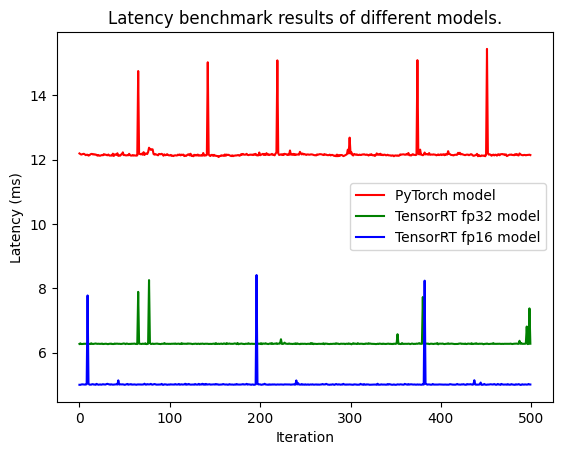

In [8]:
def inference_random_torch_timer(model, input_shape, model_type="torch", warmup_iter=500, active_iter=500):
    """Do the inference several times and get the latency."""

    # Do some warmup in case there are extra libraries and models load overhead.
    with torch.no_grad():
        for _ in range(warmup_iter):
            random_input = torch.rand(input_shape, dtype=torch.float32, device=device)
            model(random_input)

        timeaccumulate = []
        for _ in range(active_iter):
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            torch.cuda.synchronize()
            starter.record()
            model(random_input)
            ender.record()
            torch.cuda.synchronize()
            time_cur = starter.elapsed_time(ender)
            timeaccumulate.append(time_cur)
        total_time = sum(timeaccumulate)
        average_time = total_time / (len(timeaccumulate) + 1e-12)
    print(
        f"Total time for the {model_type} model: {total_time:.2f}ms.",
        f"Average time for the {model_type} model: {average_time:.2f}ms.",
    )
    return timeaccumulate


# Only test the fp32 precision torch model
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

torch_time_list = inference_random_torch_timer(model, spatial_shape, model_type="PyTorch")
trt32_time_list = inference_random_torch_timer(trt_fp32_model, spatial_shape, model_type="TensorRT fp32")
trt16_time_list = inference_random_torch_timer(trt_fp16_model, spatial_shape, model_type="TensorRT fp16")

plt.title("Latency benchmark results of different models.")
plt.xlabel("Iteration")
plt.ylabel("Latency (ms)")
plt.plot(torch_time_list, color="red", label="PyTorch model")
plt.plot(trt32_time_list, color="green", label="TensorRT fp32 model")
plt.plot(trt16_time_list, color="blue", label="TensorRT fp16 model")
plt.legend()
plt.show()

## Benchmark the end-to-end bundle run

In this part, the `workflow` defined previously is used to do the end-to-end inference. A `TimerHandler` is defined to benchmark every part of the inference process.

### Define the TimerHandler

Define a `CUDATimer` to time the latency on GPU and a `TimerHandler` to attach this timer to every part of an end-to-end inference.

In [9]:
class CUDATimer:
    def __init__(self, type_str) -> None:
        self.time_list = []
        self.type_str = type_str

    def start(self) -> None:
        self.starter = torch.cuda.Event(enable_timing=True)
        self.ender = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        self.starter.record()

    def end(self) -> None:
        self.ender.record()
        torch.cuda.synchronize()
        self.time_list.append(self.starter.elapsed_time(self.ender))

    def get_max(self) -> float:
        return max(self.time_list)

    def get_min(self) -> float:
        return min(self.time_list)

    def get_mean(self) -> float:
        np_time = np.array(self.time_list)
        return np.mean(np_time)

    def get_std(self) -> float:
        np_time = np.array(self.time_list)
        return np.std(np_time)

    def get_sum(self) -> float:
        np_time = np.array(self.time_list)
        return np.sum(np_time)

    def get_results_dict(self) -> OrderedDict:
        out_list = [
            ("total", self.get_sum()),
            ("min", self.get_min()),
            ("max", self.get_max()),
            ("mean", self.get_mean()),
            ("std", self.get_std()),
        ]
        return OrderedDict(out_list)


class TimerHandler:
    def __init__(self) -> None:
        self.run_timer = CUDATimer("RUN")
        self.epoch_timer = CUDATimer("EPOCH")
        self.iteration_timer = CUDATimer("ITERATION")
        self.net_forward_timer = CUDATimer("FORWARD")
        self.get_batch_timer = CUDATimer("PREPARE_BATCH")
        self.post_process_timer = CUDATimer("POST_PROCESS")
        self.timer_list = [
            self.run_timer,
            self.epoch_timer,
            self.iteration_timer,
            self.net_forward_timer,
            self.get_batch_timer,
            self.post_process_timer,
        ]

    def attach(self, engine: Engine) -> None:
        engine.add_event_handler(Events.STARTED, self.started, timer=self.run_timer)
        engine.add_event_handler(Events.EPOCH_STARTED, self.started, timer=self.epoch_timer)
        engine.add_event_handler(Events.ITERATION_STARTED, self.started, timer=self.iteration_timer)
        engine.add_event_handler(Events.GET_BATCH_STARTED, self.started, timer=self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.completed, timer=self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.started, timer=self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.completed, timer=self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.started, timer=self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer=self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer=self.iteration_timer)
        engine.add_event_handler(Events.EPOCH_COMPLETED, self.completed, timer=self.epoch_timer)
        engine.add_event_handler(Events.COMPLETED, self.completed, timer=self.run_timer)

    def started(self, engine: Engine, timer: CUDATimer) -> None:
        timer.start()

    def completed(self, engine: Engine, timer: CUDATimer) -> None:
        timer.end()

    def print_results(self) -> None:
        index = [x.type_str for x in self.timer_list]
        column_title = list(self.timer_list[0].get_results_dict().keys())
        column_title = [x + "/ms" for x in column_title]
        latency_list = [x for timer in self.timer_list for x in timer.get_results_dict().values()]
        latency_array = np.array(latency_list)
        latency_array = np.reshape(latency_array, (len(index), len(column_title)))
        df = pd.DataFrame(latency_array, index=index, columns=column_title)
        return df

### Benchmark the MONAI bundle

In this part, the `workflow` is updated to do the inference on the downloaded `endoscopic_tool_dataset`. It runs several iterations to benchmark the latency.

In [ ]:
workflow.dataset_dir = data_root
workflow.bundle_root = bundle_path

workflow.initialize()
torch_timer = TimerHandler()
torch_timer.attach(workflow.evaluator)
workflow.run()
workflow.finalize()

In [11]:
torch_timer.print_results()

,total/ms,min/ms,max/ms,mean/ms,std/ms
RUN,7076.975586,7076.975586,7076.975586,7076.975586,0.000000
EPOCH,7076.116211,7076.116211,7076.116211,7076.116211,0.000000
ITERATION,5810.647820,37.419552,53.915840,38.737652,1.834347
FORWARD,4244.921793,27.471424,34.854145,28.299479,1.276970
PREPARE_BATCH,733.171203,3.439424,45.551266,4.887808,3.683113
POST_PROCESS,1556.357985,9.772064,19.000769,10.375720,0.869200


### Benchmark the TensorRT fp32 and fp16 models
In this part, the `trt_fp32_model` and `trt_fp16_model` are loaded to the `workflow`. The updated `workflow` runs the same iterations as before to benchmark the latency difference. Since the `trt_fp32_model` and `trt_fp16_model` cannot be loaded through the `CheckpointLoader` and don't have `amp` mode, the `CheckpointLoader` in the `handlers` of the `workflow` needs to be removed and the `amp` parameter in the `evaluator` of the `workflow` needs to be set to `False`.

The `POST_PROCESS` and `PREPARE_BATCH` stages require a considerable amount of time. Although the model forward time is much improved, there is still room for acceleration in reducing the end-to-end latency on this particular MONAI bundle.

In [ ]:
def pop_checkpoint_loader(handlers):
    pop_index = -1
    for cnt, obj in enumerate(handlers):
        if isinstance(obj, monai.handlers.CheckpointLoader):
            pop_index = cnt
            break
    if pop_index >= 0:
        handlers.pop(pop_index)


workflow.initialize()
inference_handlers = workflow.handlers
pop_checkpoint_loader(inference_handlers)
workflow.handlers = inference_handlers
workflow.network_def = trt_fp32_model

workflow.initialize()
trt32_timer = TimerHandler()
trt32_timer.attach(workflow.evaluator)
workflow.evaluator.amp = False
workflow.run()
workflow.finalize()

In [13]:
trt32_timer.print_results()

,total/ms,min/ms,max/ms,mean/ms,std/ms
RUN,3976.694092,3976.694092,3976.694092,3976.694092,0.000000
EPOCH,3975.839111,3975.839111,3975.839111,3975.839111,0.000000
ITERATION,2692.477089,17.192833,22.593151,17.949847,0.802514
FORWARD,1114.370371,7.328000,8.935040,7.429136,0.176884
PREPARE_BATCH,702.381890,0.162880,48.027744,4.682546,4.087289
POST_PROCESS,1570.041856,9.778080,15.112832,10.466946,0.718460


In [ ]:
workflow.network_def = trt_fp16_model

workflow.initialize()
trt16_timer = TimerHandler()
trt16_timer.attach(workflow.evaluator)
workflow.evaluator.amp = False
workflow.run()
workflow.finalize()

In [15]:
trt16_timer.print_results()

,total/ms,min/ms,max/ms,mean/ms,std/ms
RUN,3920.113037,3920.113037,3920.113037,3920.113037,0.000000
EPOCH,3919.248291,3919.248291,3919.248291,3919.248291,0.000000
ITERATION,2533.983199,15.867840,24.442944,16.893221,1.204370
FORWARD,939.148706,6.074368,8.269696,6.260991,0.278483
PREPARE_BATCH,725.743360,0.170112,41.243263,4.838289,3.670066
POST_PROCESS,1586.734653,9.739744,18.202560,10.578231,1.128791
